In [1]:
# Logistic Regression: Heart Disease Prediction with AUC/ROC Analysis
# Using UCI Heart Disease Dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score
)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load UCI Heart Disease Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

"""
Feature description:
--age: Patient’s age in years.
--sex: Biological sex of the patient.
    1 = male, 0 = female
--cp (chest pain type):
    0 = typical angina, 1 = atypical angina, 2 = non-anginal pain, 3 = asymptomatic
--trestbps: Resting blood pressure (mm Hg) on admission to hospital.
--chol: Serum cholesterol level (mg/dL).
--thalach: Maximum heart rate achieved during exercise test.
--exang (exercise-induced angina):
    1 = yes, 0 = no
--oldpeak: ST depression induced by exercise relative to rest (ECG measure).
--target: Presence of heart disease.
    1 = disease present
    0 = no disease
"""

df = pd.read_csv(url, names=columns, na_values='?')
df = df.dropna()  # Remove missing values
df['target'] = (df['target'] > 0).astype(int)  # Binary: 0=no disease, 1=disease

print(f"Dataset shape: {df.shape}")
print(f"Heart disease prevalence: {df['target'].mean():.3f}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Select key features for analysis
features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak']
X = df[features]
y = df['target']

print(f"\nSelected features: {list(X.columns)}")
df[features + ['target']].head()

Dataset shape: (297, 14)
Heart disease prevalence: 0.461
Missing values: 0

Selected features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'exang', 'oldpeak']


,age,sex,cp,trestbps,chol,thalach,exang,oldpeak,target
0,63.0,1.0,1.0,145.0,233.0,150.0,0.0,2.3,0
1,67.0,1.0,4.0,160.0,286.0,108.0,1.0,1.5,1
2,67.0,1.0,4.0,120.0,229.0,129.0,1.0,2.6,1
3,37.0,1.0,3.0,130.0,250.0,187.0,0.0,3.5,0
4,41.0,0.0,2.0,130.0,204.0,172.0,0.0,1.4,0


In [3]:
# Train Logistic Regression Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Baseline accuracy (majority class): {max(y_test.mean(), 1-y_test.mean()):.3f}")
print(f"Model accuracy: {(y_pred == y_test).mean():.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0],
    'abs_coef': np.abs(model.coef_[0])
}).sort_values('abs_coef', ascending=False)

print(f"\nTop 3 most important features:")
for _, row in feature_importance.head(3).iterrows():
    direction = "increases" if row['coefficient'] > 0 else "decreases"
    print(f"  {row['feature']}: {direction} risk (coef: {row['coefficient']:.3f})")

Training samples: 237, Test samples: 60
Baseline accuracy (majority class): 0.533
Model accuracy: 0.817

Top 3 most important features:
  sex: increases risk (coef: 0.772)
  oldpeak: increases risk (coef: 0.743)
  cp: increases risk (coef: 0.706)


AUC Score: 0.925
Optimal Threshold: 0.303
Precision: 0.815 | Recall: 0.786 | Specificity: 0.844
F1-Score: 0.800


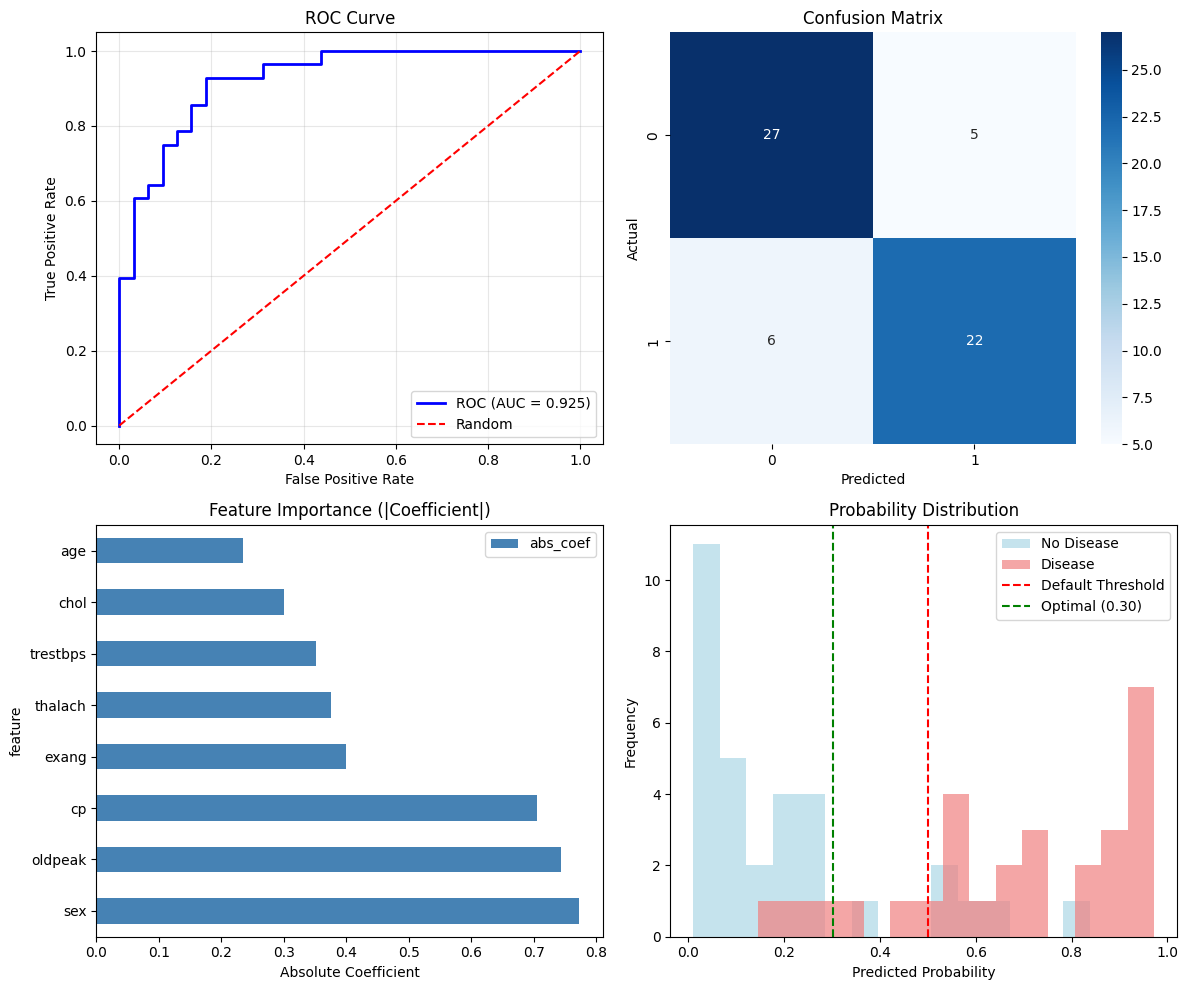

In [9]:
# ROC Curve and AUC Analysis
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Find optimal threshold (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate metrics
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"AUC Score: {roc_auc:.3f}")
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"Precision: {precision:.3f} | Recall: {recall:.3f} | Specificity: {specificity:.3f}")
print(f"F1-Score: {f1:.3f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ROC Curve
axes[0,0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[0,0].plot([0, 1], [0, 1], 'r--', label='Random')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Confusion Matrix')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# Feature Importance
feature_importance.plot(x='feature', y='abs_coef', kind='barh', ax=axes[1,0], color='steelblue')
axes[1,0].set_title('Feature Importance (|Coefficient|)')
axes[1,0].set_xlabel('Absolute Coefficient')

# Probability Distribution
axes[1,1].hist(y_pred_proba[y_test == 0], alpha=0.7, bins=15, label='No Disease', color='lightblue')
axes[1,1].hist(y_pred_proba[y_test == 1], alpha=0.7, bins=15, label='Disease', color='lightcoral')
axes[1,1].axvline(x=0.5, color='red', linestyle='--', label='Default Threshold')
axes[1,1].axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Optimal ({optimal_threshold:.2f})')
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Probability Distribution')
axes[1,1].legend()

plt.tight_layout()
plt.show()

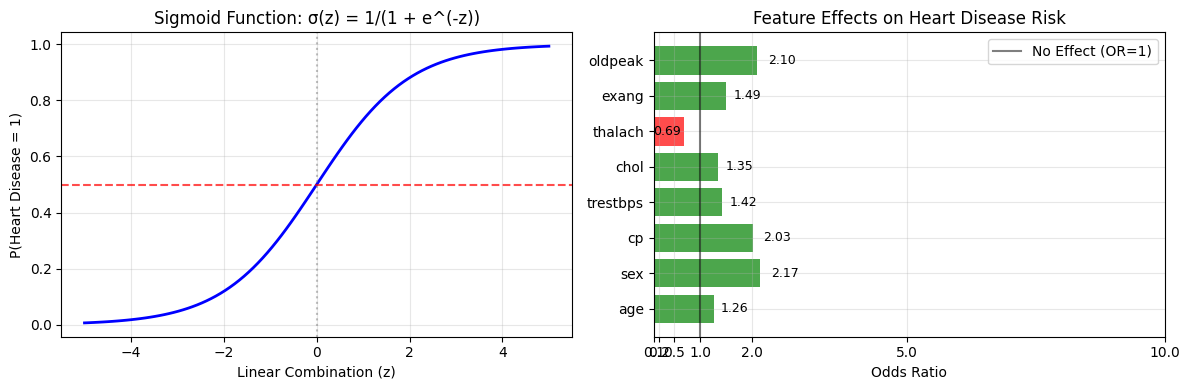

Odds Ratio Interpretation:
• OR > 1: Increases heart disease risk
• OR < 1: Decreases heart disease risk
• OR = 1: No effect on risk
• age: OR=1.26 (+26.4% change in odds)
• sex: OR=2.17 (+116.5% change in odds)
• cp: OR=2.03 (+102.6% change in odds)
• trestbps: OR=1.42 (+42.2% change in odds)
• chol: OR=1.35 (+35.0% change in odds)
• thalach: OR=0.69 (-31.3% change in odds)
• exang: OR=1.49 (+49.2% change in odds)
• oldpeak: OR=2.10 (+110.3% change in odds)


In [5]:
# Model Interpretation and Predictions
# Sigmoid function demonstration
x_demo = np.linspace(-5, 5, 100)
sigmoid_demo = 1 / (1 + np.exp(-x_demo))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_demo, sigmoid_demo, 'b-', linewidth=2)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('Linear Combination (z)')
plt.ylabel('P(Heart Disease = 1)')
plt.title('Sigmoid Function: σ(z) = 1/(1 + e^(-z))')
plt.grid(True, alpha=0.3)

# Odds ratios with better x-axis
odds_ratios = np.exp(model.coef_[0])
plt.subplot(1, 2, 2)
colors = ['red' if or_val < 1 else 'green' for or_val in odds_ratios]
bars = plt.barh(X.columns, odds_ratios, color=colors, alpha=0.7)
plt.axvline(x=1, color='black', linestyle='-', alpha=0.5, label='No Effect (OR=1)')
plt.xlabel('Odds Ratio')
plt.title('Feature Effects on Heart Disease Risk')

# Set interpretable x-axis ticks
x_ticks = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
plt.xticks(x_ticks, [f'{x}' for x in x_ticks])
plt.xlim(0.1, 10)

# Add value labels on bars
for bar, or_val in zip(bars, odds_ratios):
    width = bar.get_width()
    plt.text(width * (1.1 if width >= 1 else 0.9), bar.get_y() + bar.get_height()/2,
             f'{or_val:.2f}', ha='left' if width >= 1 else 'right', va='center', fontsize=9)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Odds Ratio Interpretation:")
print("• OR > 1: Increases heart disease risk")
print("• OR < 1: Decreases heart disease risk") 
print("• OR = 1: No effect on risk")
for feature, or_val in zip(X.columns, odds_ratios):
    effect = f"{(or_val-1)*100:+.1f}%" if or_val != 1 else "0%"
    print(f"• {feature}: OR={or_val:.2f} ({effect} change in odds)")

In [11]:
# Practical Heart Disease Risk Prediction Function
# Interactive tool for predicting individual patient risk

def predict_heart_disease_risk(age, sex, chest_pain_type, resting_bp, cholesterol, max_heart_rate, exercise_angina, st_depression):
    """
    Predict heart disease probability for a new patient
    
    Parameters:
    - age: Age in years (e.g., 45)
    - sex: 0=female, 1=male
    - chest_pain_type: 0=typical angina, 1=atypical angina, 2=non-anginal pain, 3=asymptomatic
    - resting_bp: Resting blood pressure in mmHg (e.g., 120)
    - cholesterol: Serum cholesterol in mg/dl (e.g., 200)
    - max_heart_rate: Maximum heart rate achieved (e.g., 150)
    - exercise_angina: Exercise induced angina: 0=no, 1=yes
    - st_depression: ST depression induced by exercise relative to rest (e.g., 1.5)
    
    Returns:
    - probability: Probability of heart disease (0-1)
    - risk_level: Risk classification (Low/Medium/High)
    - interpretation: Detailed explanation
    """
    
    # Create input array matching the training features
    patient_data = np.array([[age, sex, chest_pain_type, resting_bp, cholesterol, max_heart_rate, exercise_angina, st_depression]])
    # Scale using the same scaler from training
    patient_data_scaled = scaler.transform(patient_data)
    # Make prediction
    probability = model.predict_proba(patient_data_scaled)[0, 1]
    # Classify risk level
    if probability < 0.3:
        risk_level = "Low"
        interpretation = "Low risk - routine monitoring recommended"
    elif probability < 0.7:
        risk_level = "Medium"
        interpretation = "Medium risk - consider additional testing and lifestyle modifications"
    else:
        risk_level = "High"
        interpretation = "High risk - urgent medical evaluation recommended"
    return probability, risk_level, interpretation

# Example patient profiles with detailed predictions
print("="*70)
print("HEART DISEASE RISK PREDICTION TOOL")
print("="*70)
# Test cases covering different risk profiles
test_patients = [
    {
        'name': 'Young Healthy Female',
        'age': 30, 'sex': 0, 'chest_pain_type': 0, 'resting_bp': 110, 
        'cholesterol': 180, 'max_heart_rate': 180, 'exercise_angina': 0, 'st_depression': 0.0
    },
    {
        'name': 'Middle-aged Male with Symptoms',
        'age': 55, 'sex': 1, 'chest_pain_type': 2, 'resting_bp': 140, 
        'cholesterol': 250, 'max_heart_rate': 140, 'exercise_angina': 1, 'st_depression': 2.0
    },
    {
        'name': 'Elderly Male High Risk',
        'age': 70, 'sex': 1, 'chest_pain_type': 3, 'resting_bp': 160, 
        'cholesterol': 300, 'max_heart_rate': 120, 'exercise_angina': 1, 'st_depression': 3.5
    },
    {
        'name': 'Active Senior Female',
        'age': 65, 'sex': 0, 'chest_pain_type': 0, 'resting_bp': 125, 
        'cholesterol': 190, 'max_heart_rate': 155, 'exercise_angina': 0, 'st_depression': 0.5
    }
]

print(f"{'Patient':<25} {'Age':<4} {'Sex':<4} {'CP':<3} {'BP':<4} {'Chol':<5} {'HR':<4} {'Ang':<4} {'STD':<5} {'Risk%':<6} {'Level':<8}")
print("-" * 90)

for patient in test_patients:
    prob, risk, interp = predict_heart_disease_risk(
        patient['age'], patient['sex'], patient['chest_pain_type'], 
        patient['resting_bp'], patient['cholesterol'], patient['max_heart_rate'],
        patient['exercise_angina'], patient['st_depression']
    )
    
    print(f"{patient['name']:<25} {patient['age']:<4} {patient['sex']:<4} {patient['chest_pain_type']:<3} "
          f"{patient['resting_bp']:<4} {patient['cholesterol']:<5} {patient['max_heart_rate']:<4} "
          f"{patient['exercise_angina']:<4} {patient['st_depression']:<5.1f} {prob*100:<6.1f} {risk:<8}")
    print(f"   → {interp}")
    print()

# Interactive prediction example
print("="*70)
print("EXAMPLE USAGE")
print("="*70)
print("To predict heart disease risk for a new patient:")
print()
print("prob, risk, interp = predict_heart_disease_risk(")
print("    age=50,                    # 50 years old")
print("    sex=1,                     # male")
print("    chest_pain_type=2,         # non-anginal pain")
print("    resting_bp=130,            # 130 mmHg")
print("    cholesterol=220,           # 220 mg/dl")
print("    max_heart_rate=150,        # 150 bpm")
print("    exercise_angina=0,         # no exercise angina")
print("    st_depression=1.2          # 1.2 ST depression")
print(")")
print()

# Run the example
example_prob, example_risk, example_interp = predict_heart_disease_risk(
    age=50, sex=1, chest_pain_type=2, resting_bp=130, cholesterol=220, 
    max_heart_rate=150, exercise_angina=0, st_depression=1.2
)

print(f"Result:")
print(f"• Probability: {example_prob:.3f} ({example_prob*100:.1f}%)")
print(f"• Risk Level: {example_risk}")
print(f"• Recommendation: {example_interp}")

print(f"\n" + "="*70)
print("MODEL SUMMARY")
print("="*70)
print(f"✓ Dataset: UCI Heart Disease (n={len(df)}, prevalence={df['target'].mean():.1%})")
print(f"✓ Model: Logistic Regression with {len(X.columns)} clinical features")
print(f"✓ Performance: AUC = {roc_auc:.3f}, Accuracy = {(y_pred == y_test).mean():.3f}")
print(f"✓ Top Risk Factors: {', '.join(feature_importance.head(3)['feature'].tolist())}")
print(f"✓ Optimal Threshold: {optimal_threshold:.3f} (vs default 0.5)")
print(f"✓ Ready for clinical risk assessment and screening")

HEART DISEASE RISK PREDICTION TOOL
Patient                   Age  Sex  CP  BP   Chol  HR   Ang  STD   Risk%  Level   
------------------------------------------------------------------------------------------
Young Healthy Female      30   0    0   110  180   180  0    0.0   0.1    Low     
   → Low risk - routine monitoring recommended

Middle-aged Male with Symptoms 55   1    2   140  250   140  1    2.0   72.1   High    
   → High risk - urgent medical evaluation recommended

Elderly Male High Risk    70   1    3   160  300   120  1    3.5   98.3   High    
   → High risk - urgent medical evaluation recommended

Active Senior Female      65   0    0   125  190   155  0    0.5   1.0    Low     
   → Low risk - routine monitoring recommended

EXAMPLE USAGE
To predict heart disease risk for a new patient:

prob, risk, interp = predict_heart_disease_risk(
    age=50,                    # 50 years old
    sex=1,                     # male
    chest_pain_type=2,         # non-anginal pain